# SML 301: Project 2

> I pledge my honor that I have not violated the honor code when completing this assignment.

Digitally signed: Kyle Ayisi, Jess Yeager

----


## Instructions for this project



* Overview of the project (This is already provided to you.  You are welcome to add in more info, but it is fine to keep it the way it is.)
* Exploratory Data Analysis (I have provided some information about the dataset in this section.)
* Methods
* Conclusion
    + Result
    + Discussion

To make it convenient for the grader, please make all the code and outputs visible in your report.  

Some of the sections can be brief.  You will be graded on the quality, not the length, of your work.

In [1]:
# Import libraries
import os

import numpy as np
import torch # for training neural network
import torch.nn as nn
import torch.nn.functional as F # for activation functions;
                                # max pooling functions (for NLP) etc.
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter # PyTorch TensorBoard support
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt # for plotting

import datetime
from tqdm import tqdm # tqdm shows the progress bar, number of iterations,
                      # time taken to run the loop, and frequency of iterations per second

In [2]:
# Device configuration
# this will allow you to train on the gpu if your computer has one; otherwise,
# it will use the cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device # check to see if it is using a gpu or cpu

device(type='cpu')

In [3]:
%load_ext tensorboard


In [4]:
!rm -rf ./logs/

## Overview


The Cifar10 dataset contains 60000 32x32 colour images in 10 classes, with 6000 images per class (https://www.cs.toronto.edu/~kriz/cifar.html). ([This tech report](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (Chapter 3) describes the dataset and the methodology followed when collecting it in much greater detail.)  In this project we will build a neural network to classify images in Cifar10 into 10 classes.  

ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories. The images were collected from the web and labeled by human labelers using Amazon’s Mechanical Turk crowd-sourcing tool. Starting in 2010, as part of the Pascal Visual Object Challenge, an annual competition called the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) has been held. ImageNet consists of variable-resolution images. Therefore, the images have been down-sampled to a fixed resolution of 256×256. Given a rectangular image, the image is rescaled and cropped out the central 256×256 patch from the resulting image.

AlexNet is the name of a convolutional neural network which has had a large impact on the field of machine learning, specifically in the application of deep learning to machine vision. It famously won the 2012 ImageNet LSVRC-2012 competition by a large margin (15.3% VS 26.2% (second place) error rates). The network had a very similar architecture as LeNet by Yann LeCun et al but was deeper, with more filters per layer, and with stacked convolutional layers (https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/).


<img src="./AlexNet.png" alt="AlexNet" />



## Exploratory Data Analysis

The means and sd's for the channels of the Cifar10 dataset are:

mean: 0.49139968, 0.48215827, 0.44653124
std: 0.24703233, 0.24348505, 0.26158768

Similar to what we did with the MNIST dataset, we can read in the nontest set of the Cifar10 dataset and split it into training and validation sets as shown below.  What is the
image resolution (i.e., how many pixels there are in each image) for the pictures in the Cifar10 dataset? We plot the first 6 images in the training set and show their labels.

In [5]:
# mean's and sd's
train_mean, train_sd = [0.49139968, 0.48215827, 0.44653124], [ 0.24703233, 0.24348505, 0.26158768]

In [6]:
# set up training and validation sets
cifar_data = datasets.CIFAR10('data', train=True, download = True,
                            transform=transforms.Compose([
                               transforms.ToTensor(), # scale to values between 0 & 1 first.
                               transforms.Normalize( # then, normalize the data so that
                                 train_mean, train_sd) # we have mean 0 and sd 1
                             ]))



Files already downloaded and verified


In [7]:
# use the .data method to access the images:
print(type(cifar_data.data)) # what is the object type of the data?
print(len(cifar_data.data)) # how many pictures are there in `cifar_data`?
print(cifar_data.data.shape) # what are the dimensions of the data stored in `cifar_data`?
print(cifar_data.classes) # what are the unique classes of the pictures in `cifar_data`?

<class 'numpy.ndarray'>
50000
(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


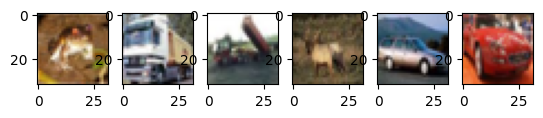

In [8]:
# plot the first 6 images in training
for k, image in enumerate(cifar_data.data[:6]):
    plt.subplot(1, 6, k+1)
    plt.imshow(image)

In [9]:
print(cifar_data.targets[:6]) # numeric class labels
print(cifar_data.classes)
# classes listed in the order of the numeric class labels;
# E.g., `airplane` is class 0, automobile' is class 1

# The labels for the first 6 images are
print([cifar_data.classes[index] for index in cifar_data.targets[:6]])

[6, 9, 9, 4, 1, 1]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile']


In [10]:
# define the values for some of the variables

# split into batches
bch_size = 32 # batch size for training
val_bch_size = 100 # validation set batch size

# number of pictures in the training and validation sets
train_size = 45000
val_size = 5000

In [11]:
cifar = list(cifar_data)

train_cifar = cifar[:train_size]

val_cifar = cifar[train_size:(train_size + val_size + 1)]

In [12]:
train_loader = torch.utils.data.DataLoader(train_cifar,
                                           batch_size=bch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_cifar,
                                         batch_size=val_bch_size,
                                         shuffle=True)

## Methods

We will build a neural network with both convolutional and dense layers to classify the Cifar10 images into 10 classes.  We will build a neural network and try to "borrow" some elements in the AlexNet architecture.  Note that AlexNet was train on 256x256 images.  However, the images that we are dealing with are smaller.  Thus, we should adjust the filter sizes, number of filters, and stride sizes accordingly.


### Baseline Model

As a baseline, please implement the following model to see what kind of accuracy and loss you can get.  Report the accuracy on the test set (you will need to load the test set yourself).  Provide graphs to show that you did not overfit the model.  Now, improve the baseline model to achieve a better performance.  Again, report the test accuracy and provide graphs to show that you did not overfit the model. As mentioned in lecture, oftentimes varying the learning rate and the batch size might affect how fast the parameter values converge, but will have little impact on the performance of the model in terms of accuracy and loss.  Therefore, I suggest just using the learning rate 0.001 and the batch size mentioned above.  


* first layer:

a convolutional layer with 64 channels with (3 x 3) filters; activation function: relu.

a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

dropout rate: 40%

* second layer:

a convolutional layer with 128 channels with (3 x 3) filters, each time move the filter 1 steps when moving horizontally and vertically; add one line of zeros to all four sides of the input for padding; activation function: relu.

a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

dropout rate: 25%

* third layer:

a convolutional layer with 256 channels with (3 x 3) filters, each time move the filter 1 steps when moving horizontally and vertically; add one line of zeros to all four sides of the input for padding; activation function: relu.

a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

dropout rate: 25%


* flatten image

* fourth layer:

dense layer with 256 neurons; activation function: relu.

* fifth layer:

dense layer with 64 neurons; activation function: relu.

* sixth layer:

dense layer with 10 neurons; activation function: softmax (no need to code the softmax function since the `CrossEntropyLoss()` function includes this part)

In [13]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.name = "baseline_model"
        self.conv1 = nn.Conv2d(3, 64, 3) #3, 8, 3
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1) # 8, 16, 3
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1) # 16, 32, 3
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        #make sure to flatten here

        self.fc1 = nn.Linear(3 * 3 * 256, 256)

        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.conv1(x))))
        x = self.dropout2(self.pool2(F.relu(self.conv2(x))))
        x = self.dropout3(self.pool3(F.relu(self.conv3(x))))
        flat = x.view(-1, 3 * 3 * 256)

        x = F.relu(self.fc1(flat))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [14]:
torch.manual_seed(2023)

net = Baseline()
print(net)

Baseline(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


After building the model, we want to train it on our training set of 45000 images, and validate it using 5000 novel images. As we do so, we calculate the average validation loss for each epoch to analyze the model's fit to unseen data.

In [15]:
#Training
val_loss_list = []
def train(model, criterion, train_loader, val_loader, logger, num_epoch,
          lr, bsize, start_epoch = 0):
    '''
    start_epoch: starting index of the first round of epoch run
    num_epoch: the number of epochs to run
    '''
    optimizer = optim.Adam(model.parameters(), lr=lr)  #is this right?

    # check if the folder `checkpoints` exists; if not, create the folder
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')

    for epoch in range(start_epoch, start_epoch + num_epoch):
        model = model.to(device) # `.to(device)` moves model to GPU (if available) to compute


        model.train() # sets the mode for training; this does not take any practical actions
        # tqdm() setup the progress bar for the training part

        with tqdm(train_loader, desc=f"Training Epoch {epoch}") as t:
            for batch_idx, (inputs, labels) in enumerate(t):
                inputs, labels = inputs.to(device), labels.to(device) # `.to(device)` moves data to GPU to compute
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad() # a clean up step for PyTorch
                loss.backward() # compute updates for each parameter
                optimizer.step() # make the updates for each parameter

                logger.add_scalar('train/loss', loss.item(), epoch*len(train_loader)+(batch_idx + 1))
                t.set_postfix({'training_loss': loss.item()}) # add a dictionary item to display
                                                              # at the end of the progress bar


        val_loss, correct = 0.0, 0
        model.eval() # sets the mode for validation;  this means avoid using dropout
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() # `a += 1` means `a = a + 1`
                # .item() returns the value of this tensor as a standard Python number
                # This only works for tensors with one element
                pred = outputs.argmax(dim=1) # predicted class with the highest predicted probability
                correct += pred.eq(labels.view_as(pred)).sum()

        ave_val_loss = val_loss / len(val_loader)
        val_acc = correct / len(val_loader.dataset)

        logger.add_histogram("conv1.bias", model.conv1.bias, epoch)
        logger.add_histogram("conv1.weight", model.conv1.weight, epoch)
        logger.add_histogram("conv2.bias", model.conv2.bias, epoch)
        logger.add_histogram("conv2.weight", model.conv2.weight, epoch)
        logger.add_histogram("conv3.bias", model.conv3.bias, epoch)
        logger.add_histogram("conv3.weight", model.conv3.weight, epoch)

        logger.add_scalar(tag = 'val/loss', scalar_value = ave_val_loss, global_step = epoch)
        logger.add_scalar('val/acc', val_acc, epoch)
        print(f'Average loss: {ave_val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100*val_acc:.1f}%)\n')
        val_loss_list.append(ave_val_loss)

        # save the updated weights after each epoch
        torch.save(model.state_dict(), f"checkpoints/lr{lr}_bsize{bsize}.pth")

In [16]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
logger = SummaryWriter(f'./logs/lr{lr}_bsize{bch_size}.pth')

In [17]:
train(net, criterion, train_loader, val_loader, logger, num_epoch=10, lr = lr, bsize = bch_size, start_epoch = 0)

Validating: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


Average loss: 1.1796, Accuracy: 2878/5000 (57.6%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Average loss: 0.9954, Accuracy: 3289/5000 (65.8%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Average loss: 0.9017, Accuracy: 3559/5000 (71.2%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Average loss: 0.8162, Accuracy: 3615/5000 (72.3%)



Validating: 100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


Average loss: 0.7709, Accuracy: 3676/5000 (73.5%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


Average loss: 0.7291, Accuracy: 3770/5000 (75.4%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


Average loss: 0.7275, Accuracy: 3783/5000 (75.7%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Average loss: 0.6988, Accuracy: 3807/5000 (76.1%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Average loss: 0.6808, Accuracy: 3863/5000 (77.3%)



Validating: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]

Average loss: 0.6585, Accuracy: 3882/5000 (77.6%)



### Improved Model (up to 3 points of extra credit for any points lost on this assignment; i.e., the maximum total score remains 100 for this assignment)

Improve the baseline model by modifying it architecture.  Show that your improved model increases the accuracy by at least 2%.

In [22]:
print(val_loss_list)

[1.1796008455753326, 0.995367671251297, 0.9017119359970093, 0.8161853003501892, 0.7708502101898194, 0.7291182482242584, 0.7274828708171844, 0.6988062852621079, 0.6808289003372192, 0.6585230404138565]


We then define a set of hyperparameters to run through, in the hopes of improving the baseline model with parameters that better suit it. This setup runs through each combination of our two hyperparameters: learning rate and batch size.

In the case we wanted to improve our baseline model, the steps are commented out below: We would want to create a dictionary of the hyperparameter values we want to test, then we would repeat what was done above but with each combination of parameters to then select the best model to use for novel data. We did not have the time to run through these different combinations but the necessary code is below.

With these various models, if one of them has better accuracy and less loss than our baseline, we could select this model and this could potentially improve our accuracy.

In [ ]:
'''
from itertools import product

#create a dictionary for the possible hyperparameter values
hyperparameters = {'lr': [0.01, 0.001], 'batch_size': [32,64,128]}

#for lr,batch_size in product(*hyperparam_values): # *hyperparam_values means taking
                             # exactly one value from each hyperparameter category at a time
#    print(lr, batch_size)
'''

In [ ]:
'''
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
device = ("cuda" if torch.cuda.is_available() else 'cpu')

tb = SummaryWriter()
model = Baseline().to(device)
train_loader = torch.utils.data.DataLoader(train_cifar, batch_size = bch_size, shuffle = True)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(train_loader))
grid = utils.make_grid(images)
tb.add_image("images", grid)
tb.add_graph(model, images)
avg_loss = []
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)

        loss = criterion(preds, labels)
        total_loss+= loss.item()
        total_correct+= get_num_correct(preds, labels)



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss.append(total_loss/len(train_loader))
    tb.add_scalar("Loss", total_loss/len(train_loader), epoch) # len(train_loader) gives
                                                               # the number of batches
    tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct/ len(train_cifar), epoch)

    tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
    tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
    tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
    tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
    tb.add_histogram("conv3.weight", model.conv3.weight, epoch)
    tb.add_histogram("conv3.bias", model.conv3.bias, epoch)

    print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss/len(train_loader))

tb.close()
'''

Lastly, we want to produce a visualization of how well the model is working on our validation set. We plot the average validation loss against the epoch number to understand this.

In [19]:
epochs = np.arange(1, 11)
print(epochs)

[ 1  2  3  4  5  6  7  8  9 10]


Text(0, 0.5, 'Validation Loss')

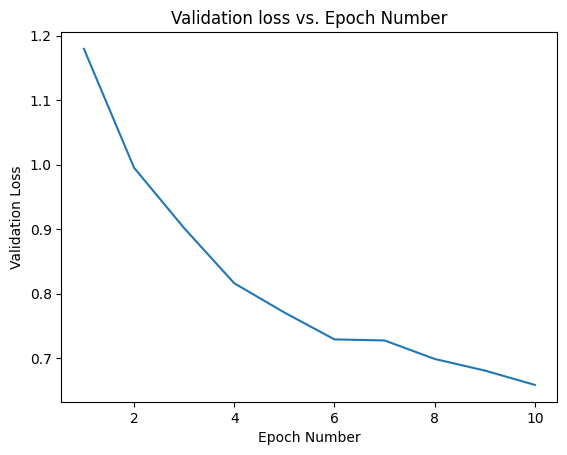

In [20]:
fig = plt.figure()
ax = plt.axes()
plt.plot(epochs, val_loss_list)
plt.title("Validation loss vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Validation Loss")

## Conclusion

Please answer the following questions in the Conclusion > Discussion section.

    
### Question 1.  Conceptual question

* Say, we have 200 gray scale images to classify.  We divide them into 10 random disjoint subsets, each with 20 images.  Each image is of 24 x 24 pixels.  We will train an artificial neural network (ANN) with 2 hidden dense layers to classify the images.  The first hidden layer has 256 neurons and the second hidden layer has 96 neurons.

For each subset of 20 images, we use forward propagation to calculate the the value of the cost function and then the back-propagation to adjust the values of the weights in the network. We will go through this procedure with one subset after another until we use up all 200 images.  

Then, we repeat the process: divide the 200 images into 10 random disjoint subsets, apply forward and back propagation to each subset until we use up all 200 images.  We repeat the process 70 times.

(Fill in the blanks with the correct answers)  In this example, the input layer should have 24 * 24 neurons, including the neuron that corresponds to the bias.  The batch size is 20, and the total number of epochs is 70.

### Question 2.  Conceptual question

When training a neural network for a binary classification problem, is it
possible for the network’s training accuracy to stay the same even while
the loss function decreases?  Explain.

Yes -- loss is a more sensitive and often better measure of model performance so loss can continue to go down while accuracy plateaus.


### Question 3.  Application

After how many epochs does the baseline model start to overfit?  Support your answer with graphs.  You can use either the `matplotlib` or `seaborn` libraries to make these graphs.  Note that TensorBoard graphs are for you to monitor the model training only and they will not show up on the pdf file of your report.

The model does not seem to overfit after 10 epochs (no plateau after 10 epochs on graph), so it may take more than 10 epochs for the validation loss to start creeping back up, a sign of overfitting.